In [1]:
#==============================================================================
# Generate data and labels
#==============================================================================
import numpy as np
from math import pi

np.random.seed(0)
m = 100
X = np.linspace(-0.95,0.95,m)
y = np.sin(np.pi*X)

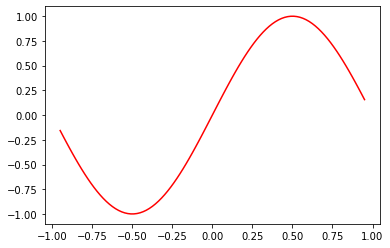

In [2]:
# plot data
import matplotlib.pyplot as plt
plt.plot(X,y,'r-')
plt.show()

In [3]:
# Encode inputs
#==============================================================================    
import qsimulator as pq
from qsimulator import RX, RY, RZ
n_qubits = 2
def input_prog(sample):
    p = pq.Program(n_qubits)
    for j in range(n_qubits):
        p.inst(RY(np.arcsin(sample[0])), j)
        p.inst(RZ(np.arccos(sample[0]**2)), j)
    return p

In [4]:
#==============================================================================
# Fully connected transverse Ising model
#==============================================================================   
from qcl import ising_prog_gen 
ising_prog = ising_prog_gen(trotter_steps=1000, T=10, n_qubits=n_qubits)

#==============================================================================
# Output state
#==============================================================================
depth = 3   
def output_prog(theta):
    p = pq.Program(n_qubits)
    theta = theta.reshape(3,n_qubits,depth)
    for i in range(depth):
        p += ising_prog
        for j in range(n_qubits):
            rj = n_qubits-j-1
            p.inst(RX(theta[0,rj,i]), j)
            p.inst(RZ(theta[1,rj,i]), j)
            p.inst(RX(theta[2,rj,i]), j)
    return p

In [5]:
#==============================================================================
# Gradients
#==============================================================================
def grad_prog(theta, idx, sign):
    theta = theta.reshape(3,n_qubits,depth)
    idx = np.unravel_index(idx, theta.shape)
    p = pq.Program(n_qubits)
    for i in range(depth):
        p += ising_prog
        for j in range(n_qubits):
            rj = n_qubits-j-1
            if idx == (0,rj,i):
                p.inst(RX(sign*np.pi/2.0), j)
            p.inst(RX(theta[0,rj,i]), j)
            if idx == (1,rj,i):
                p.inst(RZ(sign*np.pi/2.0), j)
            p.inst(RZ(theta[1,rj,i]), j)
            if idx == (2,rj,i):
                p.inst(RX(sign*np.pi/2.0), j)
            p.inst(RX(theta[2,rj,i]), j)
    return p

In [6]:
#==============================================================================
# Quantum Circuit Learning - Regression
#==============================================================================
from qsimulator import Z
from qcl import QCL

state_generators = dict()
state_generators['input'] = input_prog
state_generators['output'] = output_prog
state_generators['grad'] = grad_prog

initial_theta = np.random.uniform(0.0, 2*np.pi, size=3*n_qubits*depth)

operator = pq.Program(n_qubits)
operator.inst(Z, 0)
operator_programs = [operator] 
est = QCL(state_generators, initial_theta, loss="mean_squared_error",  
          operator_programs=operator_programs, epochs=100, batch_size=m,
          verbose=True)

est.fit(X,y)
results = est.get_results()

X_test = np.linspace(-1.0,1.0,50)
y_pred = est.predict(X_test)

Epoch: 1/100 ::: Batch: 1/1 ::: Loss: 1.12001
Epoch: 2/100 ::: Batch: 1/1 ::: Loss: 0.55464
Epoch: 3/100 ::: Batch: 1/1 ::: Loss: 0.45449
Epoch: 4/100 ::: Batch: 1/1 ::: Loss: 0.40774
Epoch: 5/100 ::: Batch: 1/1 ::: Loss: 0.35209
Epoch: 6/100 ::: Batch: 1/1 ::: Loss: 0.28608
Epoch: 7/100 ::: Batch: 1/1 ::: Loss: 0.23508
Epoch: 8/100 ::: Batch: 1/1 ::: Loss: 0.25540
Epoch: 9/100 ::: Batch: 1/1 ::: Loss: 0.25531
Epoch: 10/100 ::: Batch: 1/1 ::: Loss: 0.28613
Epoch: 11/100 ::: Batch: 1/1 ::: Loss: 0.16968
Epoch: 12/100 ::: Batch: 1/1 ::: Loss: 0.14706
Epoch: 13/100 ::: Batch: 1/1 ::: Loss: 0.13603
Epoch: 14/100 ::: Batch: 1/1 ::: Loss: 0.15640
Epoch: 15/100 ::: Batch: 1/1 ::: Loss: 0.14118
Epoch: 16/100 ::: Batch: 1/1 ::: Loss: 0.16105
Epoch: 17/100 ::: Batch: 1/1 ::: Loss: 0.13059
Epoch: 18/100 ::: Batch: 1/1 ::: Loss: 0.13893
Epoch: 19/100 ::: Batch: 1/1 ::: Loss: 0.11750
Epoch: 20/100 ::: Batch: 1/1 ::: Loss: 0.12427
Epoch: 21/100 ::: Batch: 1/1 ::: Loss: 0.11056
Epoch: 22/100 ::: Batc

Text(0, 0.5, 'Loss')

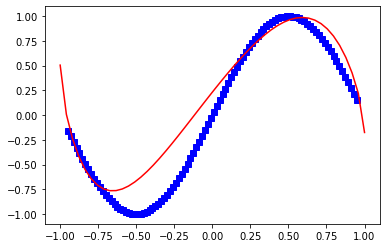

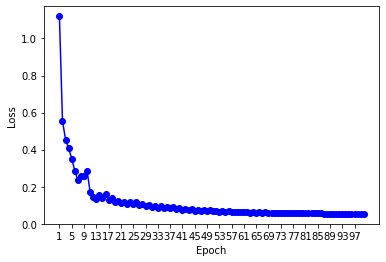

In [7]:
#==============================================================================
# PLots
#==============================================================================
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X, y, 'bs', X_test,  y_pred, 'r-')

plt.figure()
plt.plot(np.arange(1,101), results.history_loss, 'bo-')
plt.xticks(np.arange(1,101,4))
plt.xlabel('Epoch')
plt.ylabel('Loss')